# Prepare data for next-step modeling

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace
import os
from datetime import datetime
from scipy.spatial import distance_matrix
from shapely.geometry import Point
import pyproj
from haversine import haversine

P = SimpleNamespace()
P.data = "../data"
CRS_DEG = 'EPSG:4326'
CRS_M = 'EPSG:3857'

# Disp status data

In [2]:
pre_home = pd.read_parquet(P.data + "/Ida_home.parquet")
post_home = pd.read_parquet(P.data + "/Ida_dist.parquet")
merged_home = pd.read_parquet(P.data + "/disp_by_uid.parquet")

merged_home.loc[merged_home['returned_t']==-1, 'duration'] = np.nan

merged_home = merged_home[['uid', 'disp_t', 'duration']]

pre_post_home = pd.merge(pre_home, post_home, on='uid')
# pre_post_home['dist'] = pre_post_home.apply(lambda row: haversine((row['lat_x'], row['lon_x']), (row['lat_y'], row['lon_y']))//1.60934, axis = 1)
merged_home = pd.merge(merged_home, pre_post_home, on = 'uid')

merged_home['disp_wave1'] = (merged_home['disp_t']>=22*2) & (merged_home['disp_t']<29*2)
merged_home['disp_wave2'] = (merged_home['disp_t']>=29*2) & (merged_home['disp_t']<40*2) # wave2
merged_home['disp_wave3'] = (merged_home['disp_t']>=40*2) & (merged_home['disp_t']<50*2) # wave3
merged_home['disp_wave0'] = merged_home['disp_wave1'] | merged_home['disp_wave2'] | merged_home['disp_wave3']   # wave1 & wave2 & wave3

merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg').to_crs(CRS_DEG)
merged_home = gpd.GeoDataFrame(
    merged_home, geometry=gpd.points_from_xy(merged_home.lon, merged_home.lat), crs=CRS_DEG)
merged_home = gpd.sjoin(merged_home, merged_tract, op = 'within')

c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [3]:
df = merged_home

# Create empty DataFrame for results
result_df = pd.DataFrame()

# Calculate mean and std for each wave
for i in range(0, 4):
    wave_column = f"disp_wave{i}"
    temp_df = df[df[wave_column] == True]  # select only rows where wave_column is True
    temp_df = temp_df.groupby('id').agg({'dist':[np.nanmean, np.nanstd], 'duration':[np.nanmean, np.nanstd]}).reset_index()
    temp_df.columns = ['id', f'dist_wave{i}', f'dist_wave{i}_std', f'duration_wave{i}', f'duration_wave{i}_std']
    
    # merge results into result_df
    if result_df.empty:
        result_df = temp_df
    else:
        result_df = pd.merge(result_df, temp_df, on='id', how='outer')

C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\1693445878.py:10: FutureWarning: The provided callable <function nanmean at 0x000002487F3CA8C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  temp_df = temp_df.groupby('id').agg({'dist':[np.nanmean, np.nanstd], 'duration':[np.nanmean, np.nanstd]}).reset_index()
C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\1693445878.py:10: FutureWarning: The provided callable <function nanstd at 0x000002487F3CB1C0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'std' instead.
  temp_df = temp_df.groupby('id').agg({'dist':[np.nanmean, np.nanstd], 'duration':[np.nanmean, np.nanstd]}).reset_index()
C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\1693445878.py:10: FutureWarning: The provided callable <function nanmean at 0x000002487F3CA8C0> is cu

In [4]:
result_df.to_parquet(P.data+"/dist_by_merged_tract.parquet")

# COVID-19 risk data

In [5]:
df_displacement = pd.read_parquet(P.data+"/disp_by_merged_tract.parquet")
# df_displacement['disp_ratio_wave0'] = df_displacement['disp_ratio_wave1'] + df_displacement['disp_ratio_wave2'] + df_displacement['disp_ratio_wave3']
# df_displacement['return_ratio_wave0'] = (df_displacement['return_ratio_wave1']*df_displacement['disp_ratio_wave1'] + df_displacement['return_ratio_wave2']*df_displacement['disp_ratio_wave2'] + df_displacement['return_ratio_wave3']*df_displacement['disp_ratio_wave3'])/df_displacement['disp_ratio_wave0']
# df_displacement['return_ratio_wave0_7days'] = (df_displacement['return_ratio_wave1_7days']*df_displacement['disp_ratio_wave1'] + df_displacement['return_ratio_wave2_7days']*df_displacement['disp_ratio_wave2'] + df_displacement['return_ratio_wave3_7days']*df_displacement['disp_ratio_wave3'])/df_displacement['disp_ratio_wave0']

df_dest = pd.read_parquet(P.data + "/dist_by_merged_tract.parquet")

# get evacuation distance, Wave 1, Wave 2, Wave 3
df_input = pd.merge(df_displacement, df_dest, on='id', how='left')

In [6]:
vaccine = []
for filename in os.listdir(P.data + "/covid/vaccine"):
    df = pd.read_csv(P.data + "/covid/vaccine/" + filename, encoding='UTF-16', delimiter='\t')
    vaccine.append(df)
    
vaccine = pd.concat(vaccine)

cases = pd.read_csv(P.data + '/covid/weeky_cases_by_tract_LA.csv')
# cases = cases[cases['week_start']=='2021-08-19']
cases['geoid'] = cases['tract']

# Wave 1:8-18, Wave 2:8-25, Wave 3: 9-8.
vaccine_wave1 = vaccine[vaccine['admin_date']=='8/25/2021'].copy()
vaccine_wave1.drop(["admin_date", "Max. admin_date"], axis = 1, inplace=True)
vaccine_wave1.columns = ["Parish", "Completed_wave1", "Initiated_wave1"]
vaccine_wave2 = vaccine[vaccine['admin_date']=='9/1/2021'].copy()
vaccine_wave2.drop(["admin_date", "Max. admin_date"], axis = 1, inplace=True)
vaccine_wave2.columns = ["Parish", "Completed_wave2", "Initiated_wave2"]
vaccine_wave3 = vaccine[vaccine['admin_date']=='9/8/2021'].copy()
vaccine_wave3.drop(["admin_date", "Max. admin_date"], axis = 1, inplace=True)
vaccine_wave3.columns = ["Parish", "Completed_wave3", "Initiated_wave3"]

vaccine_wave0 = vaccine[vaccine['admin_date']=='9/8/2021'].copy()
vaccine_wave0.drop(["admin_date", "Max. admin_date"], axis = 1, inplace=True)
vaccine_wave0.columns = ["Parish", "Completed_wave0", "Initiated_wave0"]

vaccine = pd.merge(vaccine_wave1, pd.merge(vaccine_wave2, pd.merge(vaccine_wave3, vaccine_wave0, on='Parish'), on='Parish'), on='Parish')

# 2 weeks
case_wave1 = cases[cases['week_end'].isin(['2021-08-11', '2021-08-18', '2021-08-25'])].copy()
case_wave1 = case_wave1.groupby(["geoid"]).agg({"nPositive": np.sum, "nTests": np.sum, "nCases":np.sum}).reset_index()
# case_wave1.drop(["parish","tract","week_num", "week_start", "week_end", "nNegative"], axis = 1, inplace=True)
case_wave1.columns = ["geoid", "nPosivie_wave1", "nTest_wave1", "nCases_wave1"]

case_wave2 = cases[cases['week_end'].isin(['2021-08-18', '2021-08-25', '2021-09-01'])].copy()
# case_wave2.drop(["parish","tract","week_num", "week_start", "week_end", "nNegative"], axis = 1, inplace=True)
case_wave2 = case_wave2.groupby(["geoid"]).agg({"nPositive": np.sum, "nTests": np.sum, "nCases":np.sum}).reset_index()
case_wave2.columns = ["geoid", "nPosivie_wave2", "nTest_wave2", "nCases_wave2"]

case_wave3 = cases[cases['week_end'].isin(['2021-08-25', '2021-09-01', '2021-09-08'])].copy()
# case_wave3.drop(["parish","tract","week_num", "week_start", "week_end", "nNegative"], axis = 1, inplace=True)
case_wave3 = case_wave3.groupby(["geoid"]).agg({"nPositive": np.sum, "nTests": np.sum, "nCases":np.sum}).reset_index()
case_wave3.columns = ["geoid", "nPosivie_wave3", "nTest_wave3", "nCases_wave3"]
# case_wave3 = cases[cases['week_end'].isin(['2021-08-18', '2021-08-25', '2021-09-01', '2021-09-08'])].copy()

case_wave0 = cases[cases['week_end'].isin(['2021-08-11', '2021-08-18', '2021-08-25', '2021-09-01', '2021-09-08'])].copy()
case_wave0 = case_wave0.groupby(["geoid"]).agg({"nPositive": np.sum, "nTests": np.sum, "nCases":np.sum}).reset_index()
case_wave0.columns = ["geoid", "nPosivie_wave0", "nTest_wave0", "nCases_wave0"]

cases = pd.merge(case_wave1, pd.merge(case_wave2, pd.merge(case_wave3, case_wave0, on='geoid'), on='geoid'), on='geoid')

C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\676752284.py:31: FutureWarning: The provided callable <function sum at 0x000002487F29C160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  case_wave1 = case_wave1.groupby(["geoid"]).agg({"nPositive": np.sum, "nTests": np.sum, "nCases":np.sum}).reset_index()
C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\676752284.py:37: FutureWarning: The provided callable <function sum at 0x000002487F29C160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  case_wave2 = case_wave2.groupby(["geoid"]).agg({"nPositive": np.sum, "nTests": np.sum, "nCases":np.sum}).reset_index()
C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\676752284.py:42: FutureWarning: The provided callable <function sum at 0x000002487F29C160> is currently using Seri

In [7]:
vaccine = vaccine.drop_duplicates('Parish').reset_index(drop=True)

In [8]:
vaccine['Completed_wave0'] = vaccine['Completed_wave0'].str.rstrip('%').astype('float')
vaccine['Initiated_wave0'] = vaccine['Initiated_wave0'].str.rstrip('%').astype('float')
vaccine['Completed_wave1'] = vaccine['Completed_wave1'].str.rstrip('%').astype('float')
vaccine['Initiated_wave1'] = vaccine['Initiated_wave1'].str.rstrip('%').astype('float')
vaccine['Completed_wave2'] = vaccine['Completed_wave2'].str.rstrip('%').astype('float')
vaccine['Initiated_wave2'] = vaccine['Initiated_wave2'].str.rstrip('%').astype('float')
vaccine['Completed_wave3'] = vaccine['Completed_wave3'].str.rstrip('%').astype('float')
vaccine['Initiated_wave3'] = vaccine['Initiated_wave3'].str.rstrip('%').astype('float')

In [9]:
svi_tract = gpd.read_file(P.data + '/map/svi_tract.gpkg').to_crs(CRS_M)

svi_tract['geoid'] = svi_tract['geoid'].astype(np.int64)

# svi_tract = pd.read_csv(P.data + '/map/Louisiana.csv')
# svi_tract['geoid'] = svi_tract['FIPS'].astype(np.int64)
svi_tract.columns = [column.lower() for column in svi_tract.columns]

svi_tract = pd.merge(left=svi_tract, right = cases, on = 'geoid', how = 'left')

svi_tract = pd.merge(svi_tract, vaccine, left_on = 'county', right_on = 'Parish')

In [10]:
svi_tract = svi_tract[['geoid', 'geometry', 'e_totpop',  'nTest_wave0', 'nPosivie_wave0','nCases_wave0', 'nTest_wave1', 'nPosivie_wave1','nCases_wave1','nTest_wave2','nPosivie_wave2','nCases_wave2','nTest_wave3','nPosivie_wave3','nCases_wave3','Completed_wave0','Initiated_wave0','Completed_wave1','Initiated_wave1','Completed_wave2','Initiated_wave2','Completed_wave3','Initiated_wave3']].reset_index(drop=True)

In [11]:
svi_tract['Positive_wave0'] = svi_tract['nPosivie_wave0']/svi_tract['nTest_wave0']
svi_tract['Positive_wave1'] = svi_tract['nPosivie_wave1']/svi_tract['nTest_wave1']
svi_tract['Positive_wave2'] = svi_tract['nPosivie_wave2']/svi_tract['nTest_wave2']
svi_tract['Positive_wave3'] = svi_tract['nPosivie_wave3']/svi_tract['nTest_wave3']

svi_tract['Cases_wave0'] = svi_tract['nCases_wave0']/svi_tract['e_totpop']
svi_tract['Cases_wave1'] = svi_tract['nCases_wave1']/svi_tract['e_totpop']
svi_tract['Cases_wave2'] = svi_tract['nCases_wave2']/svi_tract['e_totpop']
svi_tract['Cases_wave3'] = svi_tract['nCases_wave3']/svi_tract['e_totpop']

In [12]:
from sklearn.neighbors import KNeighborsRegressor
# KNN for estimating missing COVID case and Positive RATIO values 
for i in range(0,4):
    non_zero = svi_tract[(svi_tract[f'Cases_wave{i}'] != 0)&(~svi_tract[f'Cases_wave{i}'].isna())].reset_index(drop=True)
    zero_case = svi_tract[(svi_tract[f'Cases_wave{i}'] == 0)|(svi_tract[f'Cases_wave{i}'].isna())].reset_index(drop=True)
    knn = KNeighborsRegressor(n_neighbors=8, weights = 'distance') 
    knn.fit(np.stack((non_zero.centroid.x, non_zero.centroid.y), axis = 1), non_zero[f'Cases_wave{i}'])
    zero_case[f'Cases_wave{i}'] = knn.predict(np.stack((zero_case.centroid.x, zero_case.centroid.y), axis = 1))
    svi_tract = pd.concat([non_zero, zero_case])

    non_zero = svi_tract[(svi_tract[f'Positive_wave{i}'] != 0)&(~svi_tract[f'Positive_wave{i}'].isna())].reset_index(drop=True)
    zero_case = svi_tract[(svi_tract[f'Positive_wave{i}'] == 0)|(svi_tract[f'Positive_wave{i}'].isna())].reset_index(drop=True)
    knn = KNeighborsRegressor(n_neighbors=8, weights = 'distance') 
    knn.fit(np.stack((non_zero.centroid.x, non_zero.centroid.y), axis = 1), non_zero[f'Positive_wave{i}'])
    zero_case[f'Positive_wave{i}'] = knn.predict(np.stack((zero_case.centroid.x, zero_case.centroid.y), axis = 1))
    svi_tract = pd.concat([non_zero, zero_case])

svi_tract['nCases_wave0'] = svi_tract['Cases_wave0']*svi_tract['e_totpop']/5
svi_tract['nCases_wave1'] = svi_tract['Cases_wave1']*svi_tract['e_totpop']/3
svi_tract['nCases_wave2'] = svi_tract['Cases_wave2']*svi_tract['e_totpop']/3
svi_tract['nCases_wave3'] = svi_tract['Cases_wave3']*svi_tract['e_totpop']/3

svi_tract['nCompleted_wave0'] = svi_tract['Completed_wave0']*svi_tract['e_totpop']
svi_tract['nCompleted_wave1'] = svi_tract['Completed_wave1']*svi_tract['e_totpop']
svi_tract['nCompleted_wave2'] = svi_tract['Completed_wave2']*svi_tract['e_totpop']
svi_tract['nCompleted_wave3'] = svi_tract['Completed_wave3']*svi_tract['e_totpop']

In [13]:
merged_tract_ = pd.read_parquet(P.data + '/repres_by_merged_tract.parquet')
merged_tract_ = merged_tract_.explode('geoids')
merged_tract_['geoids'] = merged_tract_['geoids'].astype(np.int64)
merged_home_agg = pd.merge(svi_tract, merged_tract_, left_on='geoid', right_on='geoids')

In [14]:
# drop the geoid column
merged_home_agg = merged_home_agg.drop(columns=['geoid', 'geoids'])

# Group the data by 'id','geometry','geoids','n_users','repres' and aggregate the others
merged_home_agg = merged_home_agg.groupby(['id','n_users','repres']).agg({
    'nCases_wave0': np.nansum,
    'nCases_wave1': np.nansum,
    'nCases_wave2': np.nansum,
    'nCases_wave3': np.nansum,
    'Positive_wave0': np.nanmax,
    'Positive_wave1': np.nanmax,
    'Positive_wave2': np.nanmax,
    'Positive_wave3': np.nanmax,
    'nCompleted_wave0': np.nansum,
    'nCompleted_wave1': np.nansum,
    'nCompleted_wave2': np.nansum,
    'nCompleted_wave3': np.nansum,
    'e_totpop_y':np.nanmax,
    'e_totpop_x':np.nansum
}).reset_index()

C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\1769854054.py:5: FutureWarning: The provided callable <function nansum at 0x000002487F3CA440> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  merged_home_agg = merged_home_agg.groupby(['id','n_users','repres']).agg({
C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\1769854054.py:5: FutureWarning: The provided callable <function nanmax at 0x000002487F3CA0E0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'max' instead.
  merged_home_agg = merged_home_agg.groupby(['id','n_users','repres']).agg({


In [15]:
print(np.sum(merged_home_agg['e_totpop_x']))

2820773


In [16]:
print(np.sum(merged_home_agg['e_totpop_y']))

2820773


In [17]:
merged_home_agg['Completed_wave0'] = merged_home_agg['nCompleted_wave0']/merged_home_agg['e_totpop_x']
merged_home_agg['Completed_wave1'] = merged_home_agg['nCompleted_wave1']/merged_home_agg['e_totpop_x']
merged_home_agg['Completed_wave2'] = merged_home_agg['nCompleted_wave2']/merged_home_agg['e_totpop_x']
merged_home_agg['Completed_wave3'] = merged_home_agg['nCompleted_wave3']/merged_home_agg['e_totpop_x']

merged_home_agg['Cases_wave0'] = merged_home_agg['nCases_wave0']/merged_home_agg['e_totpop_x']*100
merged_home_agg['Cases_wave1'] = merged_home_agg['nCases_wave1']/merged_home_agg['e_totpop_x']*100
merged_home_agg['Cases_wave2'] = merged_home_agg['nCases_wave2']/merged_home_agg['e_totpop_x']*100
merged_home_agg['Cases_wave3'] = merged_home_agg['nCases_wave3']/merged_home_agg['e_totpop_x']*100

In [18]:
merged_home_agg = merged_home_agg.drop(columns=['nCompleted_wave0', 'nCompleted_wave1', 'nCompleted_wave2', 'nCompleted_wave3',\
                                                'nCases_wave0', 'nCases_wave1', 'nCases_wave2', 'nCases_wave3'])

In [19]:
df_input = pd.merge(df_input, merged_home_agg, on='id', how = 'left')

# Distance to hurricane

In [20]:
from shapely.geometry import Point, LineString

# define a function to calculate the distance from a point to a line segment
def point_to_line_distance(point, line_start, line_end):
    line = LineString([line_start, line_end])
    return point.distance(line)

In [21]:
merged_tract = gpd.read_file(P.data + "/map/merged_tract.gpkg")
ida_path = gpd.read_file(P.data+"/hurricane/ida_path/points/AL092021_pts.shp")
nicho_path = gpd.read_file(P.data+"/hurricane/nicho_path/AL142021_pts.shp")
south_border = gpd.read_file(P.data+"/map/south_border.gpkg")

wgs84 = pyproj.CRS('EPSG:4326')  # geographic coordinates (longitude, latitude)
utm = pyproj.CRS('EPSG:3857') 

df_a_utm = merged_tract.to_crs(utm)
df_b_utm = ida_path.to_crs(utm)
df_c_utm = nicho_path.to_crs(utm)
df_d_utm = south_border.to_crs(utm)

# calculate distance matrix between all pairs of points in df_a and df_b， improve this
distances, distances2, distances3 = [], [], []
for i in range(len(df_a_utm)):
    res1 = 1e7
    for j in range(len(df_b_utm)-1):
      # the ith point in df_a to the line segment between the jth and (j+1)th points in df_b
      line_start = df_b_utm.geometry.iloc[j]
      line_end = df_b_utm.geometry.iloc[j+1]
      tmp = point_to_line_distance(df_a_utm.geometry.iloc[i], line_start, line_end)
      if tmp < res1:
          res1 = tmp

    distances.append(res1)

    res2 = 1e7
    for j in range(len(df_c_utm)-1):
      # the ith point in df_a to the line segment between the jth and (j+1)th points in df_b
      line_start = df_c_utm.geometry.iloc[j]
      line_end = df_c_utm.geometry.iloc[j+1]
      tmp = point_to_line_distance(df_a_utm.geometry.iloc[i], line_start, line_end)
      if tmp < res2:
            res2 = tmp
        
    distances2.append(res2)

    res3 = 1e7
    for j in range(len(df_d_utm)-1):
      # the ith point in df_a to the line segment between the jth and (j+1)th points in df_b
      line_start = df_d_utm.geometry.iloc[j]
      line_end = df_d_utm.geometry.iloc[j+1]
      tmp = point_to_line_distance(df_a_utm.geometry.iloc[i], line_start, line_end)
      if tmp < res3:
            res3 = tmp
    distances3.append(res3)

# find minimum distance for each point in df_a
min_distances = np.array(distances)
min_distances2 = np.array(distances2)
min_distances3 = np.array(distances3)

# add the list of minimum distances to dataframe A as a new column, to miles
merged_tract['dist_to_Ida'] = min_distances/1609.344
merged_tract['dist_to_Nicholas'] = min_distances2/1609.344
merged_tract['dist_to_south_bound'] = min_distances3/1609.344

# Social-demographical data

In [22]:
merged_tract_ = pd.read_parquet(P.data + '/repres_by_merged_tract.parquet')
merged_tract_ = merged_tract_.explode('geoids')

In [23]:
svi_tract = pd.read_csv(P.data + '/map/Louisiana.csv')
svi_tract['geoid'] = svi_tract['FIPS'].astype(np.int64)
svi_tract.columns = [column.lower() for column in svi_tract.columns]

In [24]:
urban = pd.read_csv(P.data+"/map/la_bgs_by_urbanity.csv")

In [25]:
# pick the first 11 digits
urban['geoid'] = urban['geoid'].astype(str).str[:11].astype(np.int64)

# group by geoid, when all urban is false, set urban to false, when all urban is true, set urban to true, when some urban is false, some is true, set urban to false
urban = urban.groupby('geoid').agg({'urban': all}).reset_index()

In [26]:
# svi_tract = gpd.read_file(P.data + '/map/svi_tract.gpkg')
# svi_tract['geoid'] = svi_tract['geoid'].astype(np.int64)
merged_tract_['geoids'] = merged_tract_['geoids'].astype(np.int64)
merged_home_agg = pd.merge(merged_tract_, svi_tract, left_on='geoids', right_on='geoid')

In [27]:
merged_home_agg = pd.merge(merged_home_agg, urban, on='geoid', how = 'left')

In [28]:
# merged_home_agg['evac_zone'].fillna(False, inplace=True)

In [29]:
# drop the geoid column
merged_home_agg = merged_home_agg.drop(columns=['geoid', 'geoids'])

# Group the data by 'id','geometry','geoids','n_users','repres' and aggregate the others
merged_home_agg = merged_home_agg.groupby(['id','n_users','repres']).agg({
    'e_totpop_y': np.nansum,
    'e_hu': np.nansum,
    'area_sqmi': np.nansum,
    'e_age17': np.nansum,
    'e_age65': np.nansum,
    'e_hisp': np.nansum,
    'e_afam': np.nansum,
    'e_asian': np.nansum,
    'e_nohsdp':np.nansum,
    'e_unemp': np.nansum,
    'e_pov150': np.nansum,
    'e_noveh': np.nansum,
    'e_uninsur': np.nansum,
    'e_disabl': np.nansum,
    'urban': np.all,
}).reset_index()

C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\1770221573.py:5: FutureWarning: The provided callable <function nansum at 0x000002487F3CA440> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  merged_home_agg = merged_home_agg.groupby(['id','n_users','repres']).agg({
C:\Users\ALei\AppData\Local\Temp\ipykernel_2764\1770221573.py:5: FutureWarning: The provided callable <function all at 0x000002487F29C3A0> is currently using SeriesGroupBy.all. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'all' instead.
  merged_home_agg = merged_home_agg.groupby(['id','n_users','repres']).agg({


In [30]:
merged_home_agg['e_totpop']= merged_home_agg['e_totpop_y']

merged_home_agg['pop_density'] = merged_home_agg['e_totpop']/merged_home_agg['area_sqmi']

merged_home_agg['urban']= merged_home_agg['urban'] & (merged_home_agg['pop_density'] > 1000)

In [31]:
merged_home_agg['ep_age17'] = merged_home_agg['e_age17']/merged_home_agg['e_totpop'] * 100
merged_home_agg['ep_age65'] = merged_home_agg['e_age65']/merged_home_agg['e_totpop'] * 100
merged_home_agg['ep_hisp'] = merged_home_agg['e_hisp']/merged_home_agg['e_totpop'] * 100
merged_home_agg['ep_afam'] = merged_home_agg['e_afam']/merged_home_agg['e_totpop'] * 100
merged_home_agg['ep_asian'] = merged_home_agg['e_asian']/merged_home_agg['e_totpop'] * 100
merged_home_agg['ep_nohsdp'] = merged_home_agg['e_nohsdp']/merged_home_agg['e_totpop'] * 100
merged_home_agg['ep_unemp'] = merged_home_agg['e_unemp']/(merged_home_agg['e_totpop']- merged_home_agg['e_age17']) * 100
merged_home_agg['ep_pov150'] = merged_home_agg['e_pov150']/merged_home_agg['e_totpop'] * 100
merged_home_agg['ep_noveh'] = merged_home_agg['e_noveh']/merged_home_agg['e_hu'] * 100
merged_home_agg['ep_uninsur'] = merged_home_agg['e_uninsur']/merged_home_agg['e_totpop'] * 100
merged_home_agg['ep_disabl'] = merged_home_agg['e_disabl']/merged_home_agg['e_totpop'] * 100

In [32]:
merged_home_agg = merged_home_agg[['id', 'area_sqmi', 'ep_age17','ep_age65', 'ep_hisp', 'ep_afam', 'ep_asian',  'ep_nohsdp', 'ep_unemp', 'ep_pov150', 'ep_noveh', 'ep_uninsur', 'ep_disabl', 'urban', 'e_totpop']].reset_index(drop = True)

In [33]:
df_input = pd.merge(df_input, merged_home_agg, on='id', how = 'left')

In [34]:
df_input = pd.merge(merged_tract, df_input, on='id')

Verify the merged_tract and repres is matched.

In [35]:
np.sum(merged_home_agg['e_totpop'])

2820773

<Axes: >

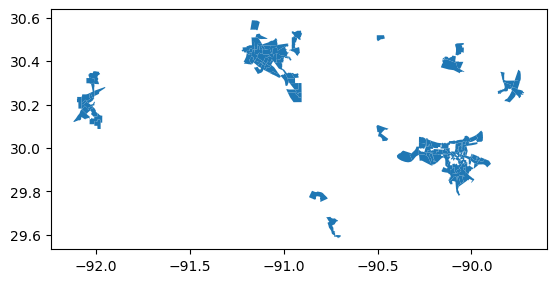

In [36]:
df_input[df_input['urban']].plot()

In [40]:
df_input.drop(columns = ['geometry'], inplace = True)
df_input.to_parquet(P.data+"/df_input_merged.parquet")